In [2]:
# import pandas as pd

In [3]:
# # Data at https://doc.mo.gov/media-center/sunshine-law
# raw_data = open("../../state/MO/MO_data/MO_raw", "r", encoding='utf-8')

# DATA CLEANING FOR MO DATA -- USING VA TEMPORARILY

In [4]:
# print(dir(raw_data))

In [5]:
# # df = pd.read_fwf("../../state/MO/MO_data/MO_raw", encoding='utf-8')
# df = pd.DataFrame()

# # Index names: https://doc.mo.gov/sites/doc/files/2018-01/sunshine_layout.xml
# # Index descriptions: https://doc.mo.gov/sites/doc/files/2018-01/sunshine_desc.xml
# # Missouri Charge is in-depth crime description code
# # CC/CS has flag whether sentences are concurrent, consecutive
# # Sentence means incarceration, probation sentence means probation
# df.index = ['DOC ID', 'Last Name', 'First Name', 'Middle Name', 'Generation/Suffix',
#             'Race', 'Sex', 'Birth Date', 'Offender Assigned Place', 'DOC Loc Func Flag',
#             'Cause Number', 'Offense County', 'Sentence County', 'NCIC Code',
#             'Missouri Charge', 'Offense Description', 'Completed Flag', 'CC/CS Ind',
#             'Sentencing Date', 'Max Release Date', 'Min Release Date',
#             'Sentence Length Years', 'Sentence Length Months', 'Sentence Length Days',
#             'Probation Sentence Date', 'Probation Type', 'Probation Term Years',
#             'Probation Term Months', 'Probation Term Days']

# count = 0
# for line in raw_data:
# #     try:
#     print(line)
# #         split_line = line.split("  ")
#     #     print(split_line)
# #         split_line_cleaned = []
# #         for section in split_line:
# #             if section != '':
# #                 split_line_cleaned.append(section)
#     #     print(line)
#     #     print(split_line_cleaned)
#     #     print(len(split_line_cleaned))

# #         new_row = [line[0:8], line[8:16]]
#     #     print(new_row)
#     #     df = pd.concat([df, split_line])

# #     except:
        
#     count += 1
    
#     if (count >= 10):
#         break
        
    
# print(count)
# # df.to_csv("../../state/MO/MO_data/MO_raw", encoding='utf-8')

In [6]:
# We're importing a bunch of libraries here that we'll be using below.

import os
import sys
import datetime
sys.path.insert(0, os.path.relpath('../../')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
from functools import partial
from datetime import date

pd.set_option('display.max_rows', 500)

# Data cleaning (WITH VA DATA)

In [7]:
raw_va_sentence_df = pd.read_csv(
    '../../state/VA/VA_data/unprocessed_va_historical_sentences_v2.csv',
    sep='\t'
)
raw_va_sentence_df['crime_type'] = raw_va_sentence_df['Offense Group'].ffill()
raw_va_sentence_df['offense_code'] = raw_va_sentence_df['VCC'].ffill()
raw_va_sentence_df['crime'] = raw_va_sentence_df['Off1VCC'].ffill()
raw_va_sentence_df['judge_id'] = raw_va_sentence_df['JudgeID'].ffill()
raw_va_sentence_df['sentence_type_code'] = raw_va_sentence_df['ActDisp'].ffill()
raw_va_sentence_df['effective_sentence_months'] = raw_va_sentence_df['effsent']
raw_va_sentence_df['fiscal_year'] = raw_va_sentence_df['FiscalYr'].ffill()
raw_va_sentence_df['life_sentence'] = raw_va_sentence_df['EffLif']
raw_va_sentence_df = raw_va_sentence_df.rename({'Off1Date':'offense_date'}, axis=1)
raw_va_sentence_df = raw_va_sentence_df[raw_va_sentence_df.sentence_type_code != 1]
raw_va_sentence_df = raw_va_sentence_df[raw_va_sentence_df.effective_sentence_months != 0]

raw_va_sentence_df = raw_va_sentence_df[~raw_va_sentence_df['crime_type'].str.contains('Total')]
raw_va_sentence_df = raw_va_sentence_df.drop(
    ['VCC', 'Offense Group', 'Off1VCC', 'JudgeID', 'ActDisp', 'effsent', 'FiscalYr', 'EffLif'],
    axis=1
)
raw_va_sentence_df.head()

,offense_date,OffLName,OffFName,crime_type,offense_code,crime,judge_id,sentence_type_code,effective_sentence_months,fiscal_year,life_sentence
0,5/20/2017,MOORE,KENNETH,ASSAULT,ASL1316,ASL1316F6,0,3.0,18.0,2018.0,0.0
1,4/25/2018,CLINE,MATTHEW,ASSAULT,ASL1316,ASL1316F6,0,3.0,10.0,2019.0,0.0
4,12/25/2016,MILLER,MARCUS,ASSAULT,ASL1316,ASL1316F6,10DB,3.0,7.0,2017.0,0.0
5,11/17/2018,SPRADLEY,CALEB,ASSAULT,ASL1316,ASL1316F6,10DB,3.0,7.0,2019.0,0.0
7,12/11/2016,JAMES,ERIC,ASSAULT,ASL1316,ASL1316F6,10KW,3.0,14.0,2017.0,0.0


In [8]:
relevant_data = raw_va_sentence_df[['offense_date', 'judge_id', 'effective_sentence_months']]
relevant_data = relevant_data.rename({'judge_id': 'Age'}, axis=1)
relevant_data['Age'] = relevant_data['Age'].apply(lambda x: np.random.randint(20,85))

In [9]:
relevant_data.head()

,offense_date,Age,effective_sentence_months
0,5/20/2017,48,18.0
1,4/25/2018,75,10.0
4,12/25/2016,22,7.0
5,11/17/2018,84,7.0
7,12/11/2016,68,14.0


# Data cleaning  (MO data)

# Preprocessing

In [10]:
sorted_data = relevant_data
sorted_data = sorted_data[~sorted_data['offense_date'].isna()]
sorted_data = sorted_data.rename({'effective_sentence_months': 'LOS'}, axis=1)

# Create age groups for the policy:
# - YOUNG = <55
# - MID = 55-60
# - OLD = 60-65
# - ELDERLY = >65

def get_age_group(age):
    if age < 55:
        return 'YOUNG'
    elif age >= 55 and age < 60:
        return 'MID'
    elif age >= 60 and age < 65:
        return 'OLD'
    else:
        return 'ELDERLY'

sorted_data['age_group'] = sorted_data['Age'].apply(get_age_group) 

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
def extract_year(date_str):
    return int(date_str.split('/')[-1])

def extract_month(date_str):
    return int(date_str.split('/')[0])

sorted_data['year'] = sorted_data['offense_date'].apply(extract_year)
sorted_data['month'] = sorted_data['offense_date'].apply(extract_month)
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month

# Create outflows table
admissions_data = sorted_data.groupby(['time_step', 'age_group']).count()[['offense_date']].reset_index().rename(
    {'offense_date': 'cohort_population'}, axis=1
)
admissions_data['compartment'] = 'pretrial'
admissions_data['admission_to'] = 'prison'
# [CHANGE 33 DEPENDING ON WHEN THE BILL COMES INTO EFFECT!!! WE THINK IT'S 66]
admissions_data = admissions_data[(admissions_data['time_step'] <= 66)] #(admissions_data['time_step'] > -108) & 
admissions_data.time_step = admissions_data.time_step.astype(int)
admissions_data.cohort_population = admissions_data.cohort_population.astype(float)
admissions_data.head()

,time_step,age_group,cohort_population,compartment,admission_to
0,-484,YOUNG,1.0,pretrial,prison
1,-468,YOUNG,1.0,pretrial,prison
2,-467,OLD,1.0,pretrial,prison
3,-447,ELDERLY,1.0,pretrial,prison
4,-443,ELDERLY,1.0,pretrial,prison


<Axes: >

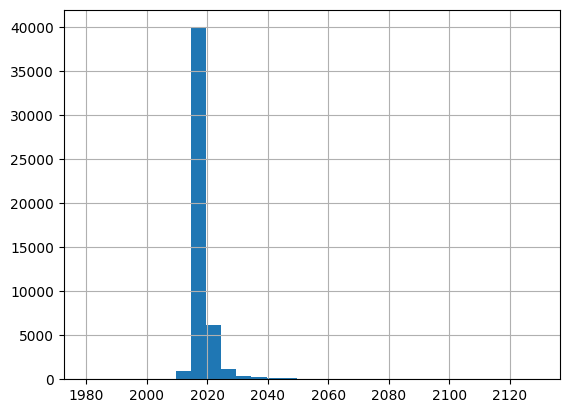

In [15]:
# distribution of release dates
release_dates = sorted_data['year'] + sorted_data['LOS']/12
release_dates[(release_dates >= 1900) & (release_dates <= 2150)].hist(bins=30)

<Axes: >

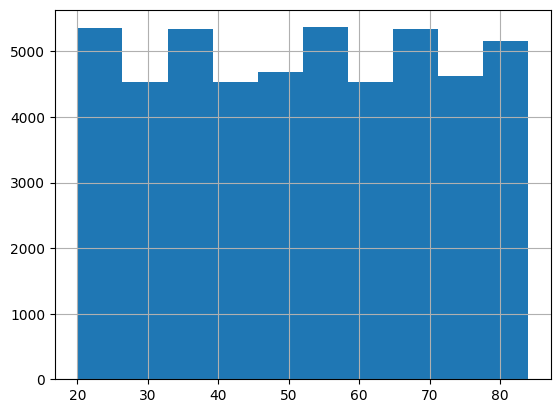

In [10]:
sorted_data['Age'].hist()

<Axes: xlabel='time_step,age_group'>

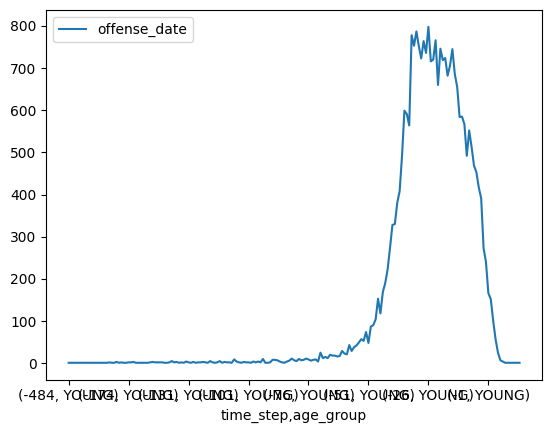

In [11]:
sorted_data[sorted_data['age_group'] == 'YOUNG'].groupby(['time_step', 'age_group']).count()[['offense_date']].plot()

In [16]:
# Create outflows table
admissions_data = sorted_data.groupby(['time_step', 'age_group']).count()[['offense_date']].reset_index().rename(
    {'offense_date': 'cohort_population'}, axis=1
)
admissions_data['compartment'] = 'pretrial'
admissions_data['admission_to'] = 'prison'
# Keep data until 2023, when we start modeling
admissions_data = admissions_data[(admissions_data['time_step'] <= 48)] #& (admissions_data['time_step'] > -108)] 
admissions_data.time_step = admissions_data.time_step.astype(int)
admissions_data.cohort_population = admissions_data.cohort_population.astype(float)
admissions_data.head()

,time_step,age_group,cohort_population,compartment,admission_to
0,-484,YOUNG,1.0,pretrial,prison
1,-468,YOUNG,1.0,pretrial,prison
2,-467,OLD,1.0,pretrial,prison
3,-447,ELDERLY,1.0,pretrial,prison
4,-443,ELDERLY,1.0,pretrial,prison


C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\1676670010.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  admissions_data.groupby('time_step').sum()['cohort_population'].plot()


<Axes: xlabel='time_step'>

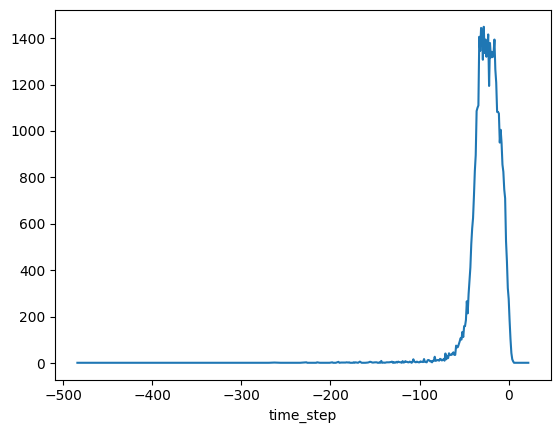

In [17]:
admissions_data.groupby('time_step').sum()['cohort_population'].plot()

In [18]:
admissions_data[~admissions_data['admission_to'].isna()]

,time_step,age_group,cohort_population,compartment,admission_to
0,-484,YOUNG,1.0,pretrial,prison
1,-468,YOUNG,1.0,pretrial,prison
2,-467,OLD,1.0,pretrial,prison
3,-447,ELDERLY,1.0,pretrial,prison
4,-443,ELDERLY,1.0,pretrial,prison
...,...,...,...,...,...
562,5,YOUNG,5.0,pretrial,prison
563,6,OLD,1.0,pretrial,prison
564,7,ELDERLY,1.0,pretrial,prison
565,9,ELDERLY,1.0,pretrial,prison


In [19]:
# CONSIDER NOT HAVING THIS AND KEEPING IT ORIGINAL. ADD A NOTE IN THE APPENDIX IF WE USE
for age in ['YOUNG', 'MID', 'OLD', 'ELDERLY']:
    admissions_data.loc[
        (admissions_data.age_group == age) & (admissions_data.time_step >= 16) & (admissions_data.time_step <= 26), 'cohort_population'
    ] = admissions_data[
        (admissions_data.age_group == age) & (((admissions_data.time_step >= 10) & (admissions_data.time_step <= 15)) | (admissions_data.time_step >= 27))
    ]['cohort_population'].mean()

C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\3368895321.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  admissions_data.groupby('time_step').sum().plot()


<Axes: xlabel='time_step'>

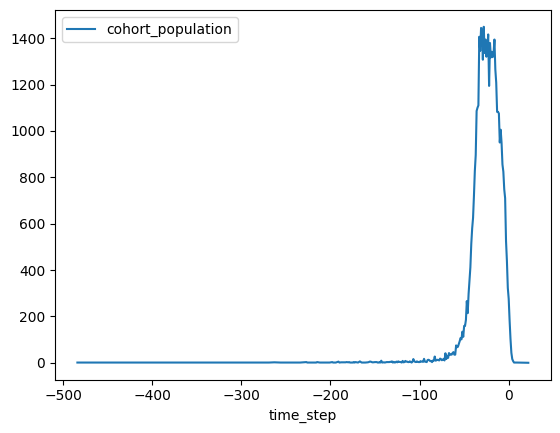

In [20]:
admissions_data.groupby('time_step').sum().plot()

In [21]:
age_groups = ['YOUNG', 'MID', 'OLD', 'ELDERLY']

# Create transitions data
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'age_group'
]).count()[['offense_date']].reset_index().rename({'offense_date': 'cohort_portion'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

# transitions_data = transitions_data.rename({"total_population": "cohort_portion"})

transitions_data = pd.concat([transitions_data, pd.DataFrame({
    'compartment_duration': [24] * len(age_groups),
    'cohort_portion': [1] * len(age_groups),
    'compartment': ['release'] * len(age_groups),
    'outflow_to': ['release'] * len(age_groups),
    'age_group': age_groups,
})], ignore_index=True)

transitions_data.cohort_portion = transitions_data.cohort_portion.astype(float)
transitions_data.head()

,compartment_duration,age_group,cohort_portion,compartment,outflow_to
0,1.0,ELDERLY,1016.0,prison,release
1,1.0,MID,282.0,prison,release
2,1.0,OLD,288.0,prison,release
3,1.0,YOUNG,1821.0,prison,release
4,2.0,ELDERLY,608.0,prison,release


C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\770214493.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(transitions_data[transitions_data['age_group'] == 'YOUNG'].groupby(['compartment_duration']).sum(), label="Young")# / transitions_data[transitions_data['age_group'] == 'YOUNG'].groupby(['compartment_duration']).sum().mean())
C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\770214493.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(transitions_data[transitions_data['age_group'] == 'MID'].groupby(['compartment_duration']).sum(), label="Mid")# / transitions_data[transitions_data['

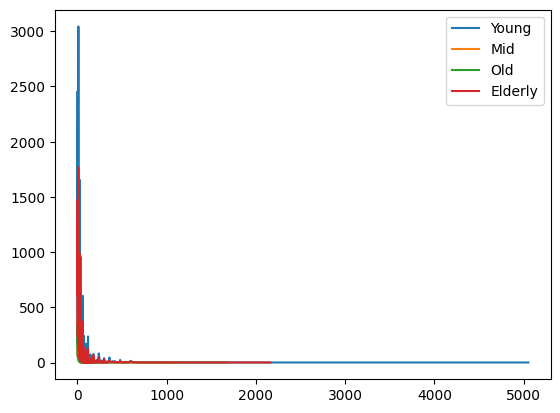

In [22]:
# young_transitions = transitions_data[transitions_data['age_group'] == 'ELDERLY']
# young_transitions.head()
plt.plot(transitions_data[transitions_data['age_group'] == 'YOUNG'].groupby(['compartment_duration']).sum(), label="Young")# / transitions_data[transitions_data['age_group'] == 'YOUNG'].groupby(['compartment_duration']).sum().mean())
plt.plot(transitions_data[transitions_data['age_group'] == 'MID'].groupby(['compartment_duration']).sum(), label="Mid")# / transitions_data[transitions_data['age_group'] == 'MID'].groupby(['compartment_duration']).sum().mean())
plt.plot(transitions_data[transitions_data['age_group'] == 'OLD'].groupby(['compartment_duration']).sum(), label="Old")# / transitions_data[transitions_data['age_group'] == 'OLD'].groupby(['compartment_duration']).sum().mean())
plt.plot(transitions_data[transitions_data['age_group'] == 'ELDERLY'].groupby(['compartment_duration']).sum(), label="Elderly")# / transitions_data[transitions_data['age_group'] == 'ELDERLY'].groupby(['compartment_duration']).sum().mean())
plt.legend()

# plt.plot(young_transitions.cohort_portion)
# age_grouped_transitions = transitions_data.groupby(['age_group', 'cohort_portion']).sum()
# age_grouped_transitions.reset_index()
# age_grouped_transitions.head()
# plt.plot(age_grouped_transitions.compartment_duration)

In [23]:
#Create alternate transitions table for policy scenario
# FINISH THIS!!!

# This estimates resentencing frequency/outcomes using the parole set-off system used in Texas
# see https://www.secondlooktexas.org/action
GRANT_RATE = 0.5  # PREVIOUSLY 3 / (32 + 3) -- JUST TESTING

# If rejected, must wait a year to reapply
# Adding an extra year for processing and re-application time
SETOFF_TIME = 24
alternate_transitions_data = pd.DataFrame()

# Tiers set by crime type -- tier 0 is not included because it means ineligible
# TIERS = transitions_data['age_group'].unique().astype("int64")
# Months of sentence that must be served to be eligible for parole
age_group_sentence_lengths = [float("NaN"), 15 * 12, 10 * 12, 5 * 12]


for age_group_enum in enumerate(age_groups):
    age_group_idx, age_group = age_group_enum
    eligible_data = transitions_data[
        (transitions_data['compartment'] == 'prison')
        & (transitions_data['age_group'] == age_group)
    ].copy()

    if eligible_data.size > 0 and age_group == 'YOUNG':
        eligible_data = eligible_data.groupby([
            'compartment', 'compartment_duration', 'age_group', 'outflow_to'
        ], as_index=False).sum()
        
        # The model breaks if the maximum LOS gets shorter in the new data, so if that's the case, then change it
        # so the last line of data has a tiny tiny population
        eligible_data.loc[max(eligible_data.index), 'cohort_portion'] = max(eligible_data.loc[max(eligible_data.index), 'cohort_portion'], 10**(-5))
        
        # append our work to the new transitions_data we're building
        alternate_transitions_data = pd.concat([alternate_transitions_data, eligible_data])

    elif eligible_data.size > 0:
        for i in range(age_group_sentence_lengths[age_group_idx], int(eligible_data.compartment_duration.max()), SETOFF_TIME):
            rate = GRANT_RATE
            
            # calculate population that still hasn't been released by now
            remaining_population = eligible_data.loc[
                eligible_data['compartment_duration'] > i, 'cohort_portion'
            ].sum()

            print("Total population before", eligible_data['cohort_portion'].sum())
            
            # reduce the population size of people staying in prison longer than this by the number of people being
            # released via resentencing right now
            eligible_data.loc[eligible_data['compartment_duration'] > i, 'cohort_portion'] *= 1 - rate
            
            # add in rows of data for the people being released right now via resentencing
            eligible_data = pd.concat([eligible_data, pd.DataFrame({
                'compartment_duration': [i],
                'cohort_portion': [rate*remaining_population],
                'age_group': [age_group],
                'compartment': ['prison'],
                'outflow_to': ['release']
            })], ignore_index=True)

            print("Total population after", eligible_data['cohort_portion'].sum())
        
        eligible_data = eligible_data.groupby([
            'compartment', 'compartment_duration', 'age_group', 'outflow_to'
        ], as_index=False).sum()
        
        # The model breaks if the maximum LOS gets shorter in the new data, so if that's the case, then change it
        # so the last line of data has a tiny tiny population
        eligible_data.loc[max(eligible_data.index), 'cohort_portion'] = max(eligible_data.loc[max(eligible_data.index), 'cohort_portion'], 10**(-5))
        
        # append our work to the new transitions_data we're building
        alternate_transitions_data = pd.concat([alternate_transitions_data, eligible_data])

# Round population numbers to avoid tiny populations in weird places
alternate_transitions_data.cohort_portion = alternate_transitions_data.cohort_portion.apply(lambda x: round(x, 5))
# drop the rows that are now rounded to zero
alternate_transitions_data = alternate_transitions_data[alternate_transitions_data.cohort_portion > 0]

alternate_transitions_data = pd.concat([alternate_transitions_data, pd.DataFrame({
    'compartment_duration': [24] * len(age_groups),
    'cohort_portion': [1] * len(age_groups),
    'compartment': ['release'] * len(age_groups),
    'outflow_to': ['release'] * len(age_groups),
    'age_group': list(age_groups),
})], ignore_index=True)

alternate_transitions_data.cohort_portion = alternate_transitions_data.cohort_portion.astype(float)
alternate_transitions_data.head()

Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 3767.0
Total population after 3767.0
Total population before 

,compartment,compartment_duration,age_group,outflow_to,cohort_portion
0,prison,1.0,YOUNG,release,1821.0
1,prison,2.0,YOUNG,release,1232.0
2,prison,3.0,YOUNG,release,2456.0
3,prison,4.0,YOUNG,release,854.0
4,prison,5.0,YOUNG,release,353.0


In [26]:
# change names to fit model expectations
admissions_data = admissions_data.rename(
    {'age_group': 'simulation_group'},
    axis=1
)
admissions_data['simulation_group'] = admissions_data['simulation_group'].astype(str)
admissions_data['time_step'] = admissions_data['time_step'].astype('int64')

transitions_data = transitions_data.rename(
    {'age_group': 'simulation_group'},
    axis=1
)
transitions_data['simulation_group'] = transitions_data['simulation_group'].astype(str)

alternate_transitions_data = alternate_transitions_data.rename(
    {'age_group': 'simulation_group'},
    axis=1
)
alternate_transitions_data['simulation_group'] = alternate_transitions_data['simulation_group'].astype(str)

C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\2113284582.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(transitions_data[transitions_data['simulation_group'] == 'OLD'].groupby(['compartment_duration']).sum(), label="transitions")
C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\2113284582.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(alternate_transitions_data[alternate_transitions_data['simulation_group'] == 'OLD'].groupby(['compartment_duration']).sum(), label="alternate transitions")


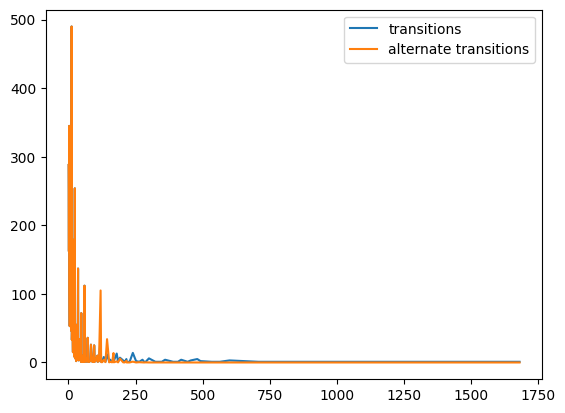

In [27]:
plt.plot(transitions_data[transitions_data['simulation_group'] == 'OLD'].groupby(['compartment_duration']).sum(), label="transitions")
plt.plot(alternate_transitions_data[alternate_transitions_data['simulation_group'] == 'OLD'].groupby(['compartment_duration']).sum(), label="alternate transitions")
plt.legend()

C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\2370120996.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  transitions_dist = transitions_data[transitions_data['simulation_group'] == 'ELDERLY'].groupby(['compartment_duration']).sum().reset_index()
C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\2370120996.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  alternate_transitions_dist = alternate_transitions_data[alternate_transitions_data['simulation_group'] == 'ELDERLY'].groupby(['compartment_duration']).sum().reset_index()


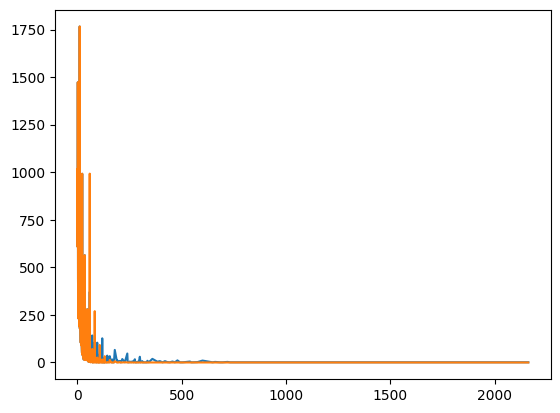

In [28]:
transitions_dist = transitions_data[transitions_data['simulation_group'] == 'ELDERLY'].groupby(['compartment_duration']).sum().reset_index()
#plt.scatter(x=transitions_dist['compartment_duration'], y=transitions_dist['cohort_portion'])
plt.plot(transitions_dist['compartment_duration'], transitions_dist['cohort_portion'])

alternate_transitions_dist = alternate_transitions_data[alternate_transitions_data['simulation_group'] == 'ELDERLY'].groupby(['compartment_duration']).sum().reset_index()
#plt.scatter(x=alternate_transitions_dist['compartment_duration'], y=alternate_transitions_dist['cohort_portion'])
plt.plot(alternate_transitions_dist['compartment_duration'], alternate_transitions_dist['cohort_portion'])


C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\3368895321.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  admissions_data.groupby('time_step').sum().plot()


<Axes: xlabel='time_step'>

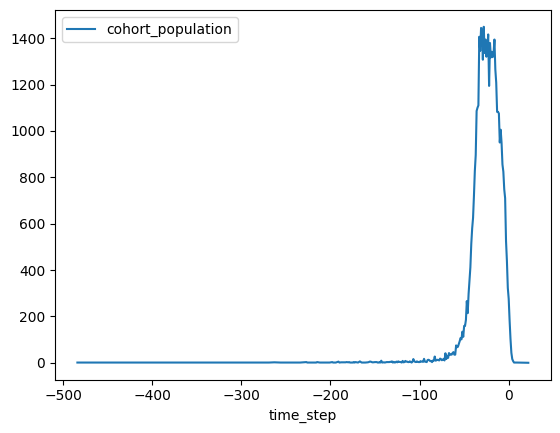

In [29]:
admissions_data.groupby('time_step').sum().plot()

In [30]:
sorted_data.groupby(['year']).count()

,offense_date,Age,LOS,age_group,month,time_step
year,,,,,,
1978,1,1,1,1,1,1
1979,1,1,1,1,1,1
1980,1,1,1,1,1,1
1981,1,1,1,1,1,1
1982,1,1,1,1,1,1
1988,1,1,1,1,1,1
1990,2,2,2,2,2,2
1992,2,2,2,2,2,2
1993,1,1,1,1,1,1


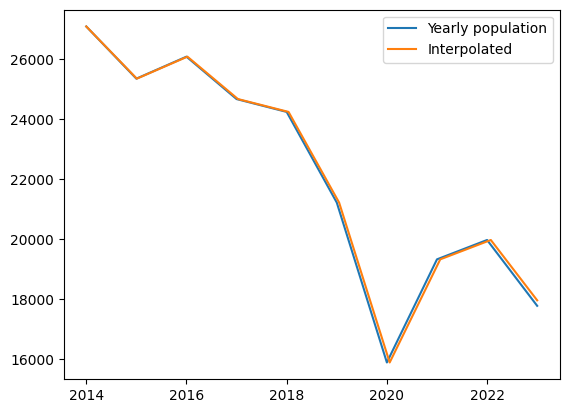

In [31]:
# From https://doc.mo.gov/media/pdf/offender-profile-fy23
total_pop = {
    2014: 27091,
    2015: 25352,
    2016: 26085,
    2017: 24672,
    2018: 24244,
    2019: 21223,
    2020: 15894,
    2021: 19331,
    2022: 19976,
    2023: 17782
    # 2014: 31889,
    # 2015: 32273,
    # 2016: 32831,
    # 2017: 32805,
    # 2018: 31724,
    # 2019: 28172,
    # 2020: 24010,
    # 2021: 23137,
    # 2022: 23496,
    # 2023: 23595
}

# Interpolates yearly numbers to estimate monthly
def lerp(pop_start, pop_end):
    months = range(12)
    monthly_pop = []
    
    for month in months:
        # Linear interpolation between pop_start and pop_end
        pop = (pop_start * (12 - month) + pop_end * month) / 12
        monthly_pop.append(pop)
    
    return monthly_pop
    
monthly_populations = []

for year in total_pop:
    if year < 2023:#< 2023:
        monthly_populations += lerp(total_pop[year], total_pop[year + 1])
    
# Plot to check interpolation worked properly
plt.plot(np.arange(2014, 2024), [total_pop[year] for year in total_pop], label="Yearly population")
plt.plot(np.linspace(2014, 2023, len(monthly_populations)), monthly_populations, label="Interpolated")
plt.legend()

In [32]:
population_data = pd.DataFrame({
    'time_step': range(len(monthly_populations)),
    'compartment_population': monthly_populations
})
population_data['compartment'] = 'prison'
population_data['compartment_population'] = population_data['compartment_population'].astype(float)
population_data['time_step'] -= 5 * 12 # Makes time_step relative to reference year (2019, or 5*12 timesteps after 2014)

population_data.loc[len(population_data.index)] = population_data.loc[len(population_data.index) - 1]
population_data.loc[len(population_data.index) - 1, "time_step"] = 48

In [33]:
population_data

,time_step,compartment_population,compartment
0,-60,27091.000000,prison
1,-59,26946.083333,prison
2,-58,26801.166667,prison
3,-57,26656.250000,prison
4,-56,26511.333333,prison
5,-55,26366.416667,prison
6,-54,26221.500000,prison
7,-53,26076.583333,prison
8,-52,25931.666667,prison
9,-51,25786.750000,prison


In [34]:
transitions_data['simulation_group'].unique()

array(['ELDERLY', 'MID', 'OLD', 'YOUNG'], dtype=object)

## Adjustments to make sure the model doesn't break

C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\3368895321.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  admissions_data.groupby('time_step').sum().plot()


<Axes: xlabel='time_step'>

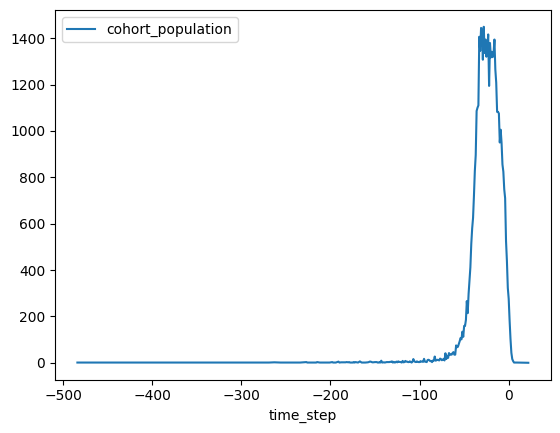

In [35]:
admissions_data.groupby('time_step').sum().plot()

In [36]:
# Ensure admissions has data for each simulation group
for i in range(admissions_data['time_step'].min(), admissions_data['time_step'].max()):
    addtl_admissions = pd.DataFrame({
        'simulation_group': age_groups,
        'time_step': [i] * len(age_groups),
        'compartment': ['pretrial'] * len(age_groups),
        'cohort_population': [1e-5] * len(age_groups),
        'admission_to': ['prison'] * len(age_groups)
    })
    admissions_data = pd.concat([admissions_data, addtl_admissions], ignore_index=True)

In [37]:
# Ensure transitions has data for each simulation group
addtl_transitions = pd.DataFrame({
    'simulation_group': age_groups,
    'compartment': ['prison']*len(age_groups),
    'compartment_duration': [24]*len(age_groups),
    'cohort_portion': [1e-5]*len(age_groups),
    'outflow_to': ['release']*len(age_groups)
})

transitions_data = pd.concat([transitions_data, addtl_transitions], ignore_index=True)

In [38]:
# Change compartment duration to float64
transitions_data['compartment_duration'] = transitions_data['compartment_duration'].astype('float64')

In [39]:
# Ensure alternate transitions has data for each simulation group
alternate_transitions_data = pd.concat([alternate_transitions_data, addtl_transitions], ignore_index=True)

In [40]:
# There are a bunch of null transitions... TODO: figure out why
transitions_data = transitions_data[~transitions_data.isnull().any(axis=1)]

# Running a baseline

C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\3368895321.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  admissions_data.groupby('time_step').sum().plot()


<Axes: xlabel='time_step'>

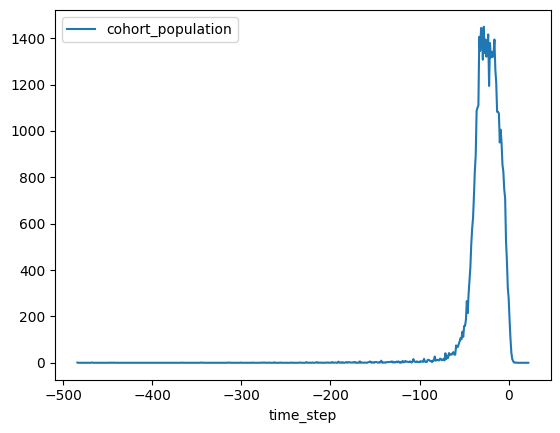

In [41]:
admissions_data.groupby('time_step').sum().plot()

In [42]:
transitions_data[transitions_data["compartment"] == 'prison']["outflow_to"].unique()

array(['release'], dtype=object)

Showed that even setting admissions to be constant in time doesn't prevent the "lower bound hit when predicting admissions" error and subsequent blowup

In [43]:
# for age in ['YOUNG', 'MID', 'OLD', 'ELDERLY']:
#     admissions_data[admissions_data['simulation_group'] == age].cohort_population = admissions_data[admissions_data['simulation_group'] == age].cohort_population.mean()

In [44]:
# transitions_data.head()
# transitions_data.groupby(['simulation_group', 'compartment_duration']).sum()
transitions_data[transitions_data['simulation_group'] == 'ELDERLY']

,compartment_duration,simulation_group,cohort_portion,compartment,outflow_to
0,1.0,ELDERLY,1016.00000,prison,release
4,2.0,ELDERLY,608.00000,prison,release
8,3.0,ELDERLY,1473.00000,prison,release
12,4.0,ELDERLY,442.00000,prison,release
16,5.0,ELDERLY,232.00000,prison,release
20,6.0,ELDERLY,1283.00000,prison,release
24,7.0,ELDERLY,607.00000,prison,release
28,8.0,ELDERLY,324.00000,prison,release
32,9.0,ELDERLY,494.00000,prison,release
36,10.0,ELDERLY,319.00000,prison,release


In [65]:
admissions_data = admissions_data[admissions_data['cohort_population'].notna()]

In [66]:
# STEP 1: pick a `simulation_tag` for your simulation. "ayesha_parole_test" would be a reasonable example...
# Make sure you go to the yaml configuration and change the simulation tag there. Here's the path for finding the 
# yaml configuration:'../../state/VA/2022/test_configurations/walkthru_user_inputs.yaml')

simulation_tag = "MO_compassionate_release_2024"


upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    admissions_data,
    transitions_data,
    population_data,
    '../../state/MO/2024/MO_compassionate_release_2024.yaml',
)

C:\Users\isaac\.virtualenvs\sdc-data-science-iCMpQ41f\lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [67]:
# Don't worry about any warnings. As long as this doesn't fail, you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../../state/MO/2024/MO_compassionate_release_2024.yaml'
)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


initialization time:  7.396970272064209


simulation_time:  8.520150661468506


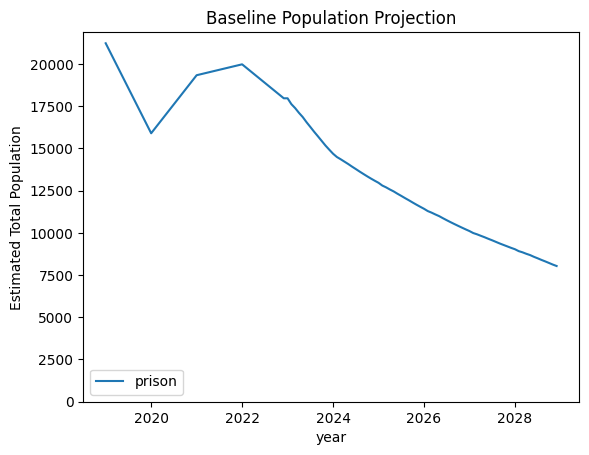

In [68]:
#This can take several minutes to run. You'll see six checkpoints printed out along the way before it finishes.
display_compartments = ['prison']
spark_sim.simulate_baseline(display_compartments)

C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\2791809803.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  admissions_data.groupby('time_step').sum().plot()


<Axes: xlabel='time_step'>

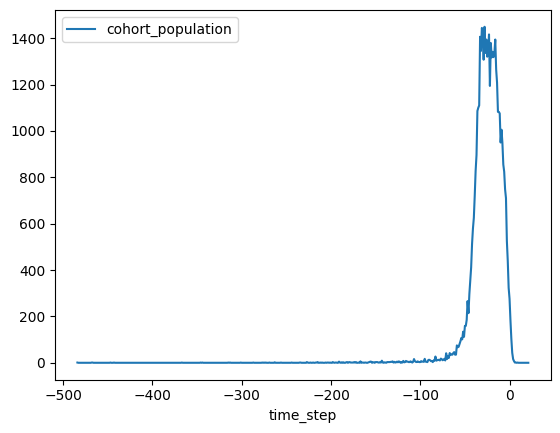

In [69]:
# plt.hist(relevant_data.year)
admissions_data.groupby('time_step').sum().plot()
# relevant_data[relevant_data['year'] > 2000].groupby('year').count().plot()
# transitions_data.head()
# transitions_data[transitions_data['compartment_duration'] > 200].groupby('compartment_duration').sum().plot()

In [70]:
admissions_data.groupby('time_step').sum()
# admissions_data.head()

C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\782128705.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  admissions_data.groupby('time_step').sum()


,cohort_population
time_step,
-484,1.00004
-483,0.00004
-482,0.00004
-481,0.00004
-480,0.00004
...,...
17,0.00004
18,0.00004
19,0.00004


[<Axes: title={'center': 'compartment: pretrial\nadmission_to: prison'}, xlabel='time_step'>]

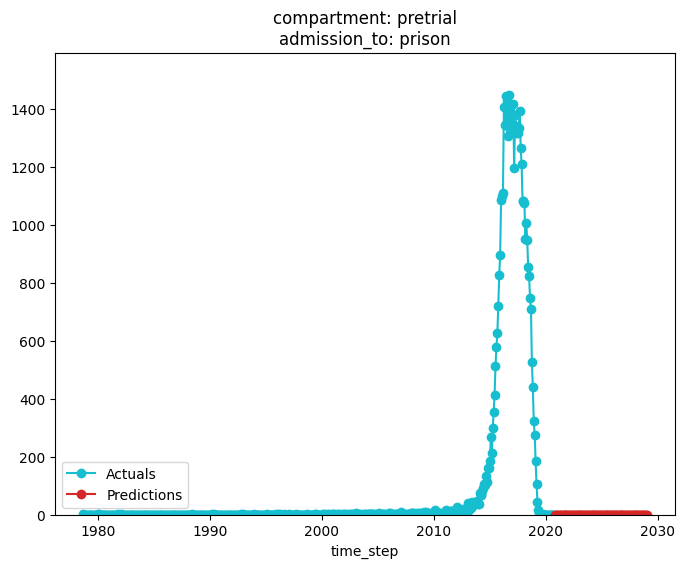

In [71]:
spark_sim.get_arima_output_plots('baseline_projections')

initialization time:  7.193981885910034
initialization time:  7.309910774230957
simulation_time:  8.643062114715576


simulation_time:  8.55411696434021
23345.300000000003


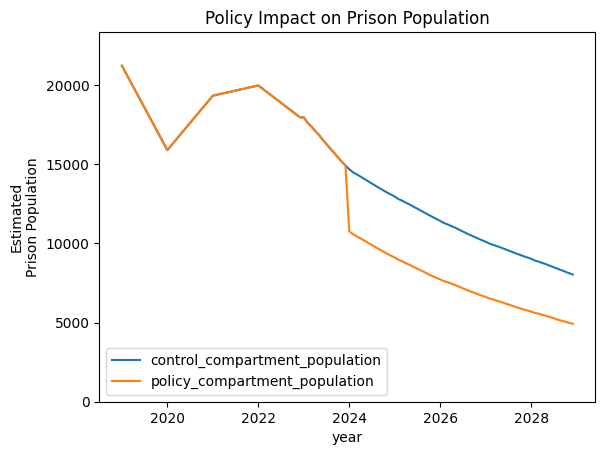

In [72]:
def second_look(age_group):
    return SparkPolicy(
        spark_compartment='prison',
        simulation_group=age_group,
        alternate_transitions_data=alternate_transitions_data[alternate_transitions_data['simulation_group'] == age_group],
        apply_retroactive=True,
        policy_time_step=60 # Start in FY 2025 (36 timesteps after FY 2022)
    )

policy_list = []
for age_group in age_groups:
    policy_list.append(second_look(age_group))

test_results = spark_sim.simulate_policy(policy_list, 'prison')

In [73]:
# alternate_transitions_data.head(10000)
transitions_data.groupby(["compartment_duration", "compartment"]).sum()

C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\2753729819.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  transitions_data.groupby(["compartment_duration", "compartment"]).sum()


,,cohort_portion
compartment_duration,compartment,
1.0,prison,3407.00000
2.0,prison,2170.00000
3.0,prison,4642.00000
4.0,prison,1515.00000
5.0,prison,691.00000
6.0,prison,4013.00000
7.0,prison,2018.00000
8.0,prison,1124.00000
9.0,prison,1562.00000


In [74]:
alternate_transitions_data.groupby(["compartment_duration", "compartment"]).sum()

C:\Users\isaac\AppData\Local\Temp\ipykernel_34040\3003116013.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  alternate_transitions_data.groupby(["compartment_duration", "compartment"]).sum()


,,cohort_portion
compartment_duration,compartment,
1.0,prison,3407.00000
2.0,prison,2170.00000
3.0,prison,4642.00000
4.0,prison,1515.00000
5.0,prison,691.00000
6.0,prison,4013.00000
7.0,prison,2018.00000
8.0,prison,1124.00000
9.0,prison,1562.00000


In [75]:
simulation_tag = 'MO_compassionate_release_2024'
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


{'spending_diff':                        prison release
 year                                 
 2019.000000               0.0     0.0
 2019.083333               0.0     0.0
 2019.166667               0.0     0.0
 2019.250000               0.0     0.0
 2019.333333               0.0     0.0
 2019.416667               0.0     0.0
 2019.500000               0.0     0.0
 2019.583333               0.0     0.0
 2019.666667               0.0     0.0
 2019.750000               0.0     0.0
 2019.833333               0.0     0.0
 2019.916667               0.0     0.0
 2020.000000               0.0     0.0
 2020.083333               0.0     0.0
 2020.166667               0.0     0.0
 2020.250000               0.0     0.0
 2020.333333               0.0     0.0
 2020.416667               0.0     0.0
 2020.500000               0.0     0.0
 2020.583333               0.0     0.0
 2020.666667               0.0     0.0
 2020.750000               0.0     0.0
 2020.833333               0.0     0.0
 2020.91

In [76]:
len(sorted_data[(sorted_data['age_group'] == 'MID') & ((2025 - sorted_data['year']) >= 15) & ((2025 - sorted_data['year']) <= sorted_data['LOS']/12)])

2